# Getting started

This tutorial helps you to learn the basic concepts and practices of Pax.

In this tutorial, you will learn:

1. Pax uses a global variable to store a global random key.
2. How to register trainable parameters and non-trainable states.
3. A loss function should have a separate argument for trainable parameters.
4. A loss function should return the updated model to make the updates available to the outside world.
5. A loss function should have no side effects.
6. `pax.grad`, the Pax's edition of `jax.grad`, transforms a loss function to its gradient function.


Let's start our journey by importing `jax` and `pax`.

In [1]:
# uncomment the following line to install pax
# !pip install -q git+https://github.com/NTT123/pax.git

In [2]:
import jax
import jax.numpy as jnp
import pax

To demonstrate the basics of ``pax.Module``, we will define a simple ``Linear`` module with an _additional_ `forward pass` counter.

In [3]:
class Linear(pax.Module):
    """A Linear module has two real parameters ``weight`` and ``bias``."""

    weight: jnp.ndarray
    bias: jnp.ndarray
    counter: jnp.ndarray #  used to count number of forward pass (__call__ executions)

    def __init__(self):
        super().__init__()

        self.register_parameters("weight", jnp.array(1.0))
        self.register_parameters("bias", jnp.array(0.0))
        self.register_states("counter", jnp.array(0))
    
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        self.counter = self.counter + 1
        return self.weight * x + self.bias
        
    def __str__(self):
        return f"weight={self.weight} bias={self.bias} counter={self.counter}"

net = Linear()
print(net)

weight=1.0 bias=0.0 counter=0


**Note**: 

1. `self.register_parameters(...)` registers `weight` and `bias` as _trainable parameters_. 
2. `self.register_states(...)` registers `counter` as a _non-trainable_ state.

Next, we will create a toy dataset and fit ``net`` with that dataset.

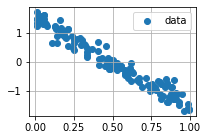

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3,2)


pax.seed_rng_key(42) # seeding pax random key

def create_data(a=-3.0, b=1.5):
    x = jax.random.uniform(pax.next_rng_key(), (128, 1))
    noise = jax.random.normal(pax.next_rng_key(), x.shape) * 0.2
    y = a * x + b + noise
    plt.scatter(x, y)
    plt.grid('on')
    plt.legend(["data"])
    plt.show()
    return x, y

x, y = create_data()

Pax keeps a global random key at `pax.rng.state._rng_key`. We use ``pax.seed_rng_key(42)`` to seed that global random key.

The function `pax.next_rng_key()` will return a new `rng_key` and also renew the global random key

Now, plot the initial _predictions_ of our `Linear` model.

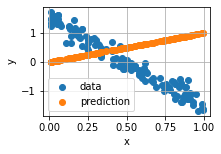

weight=1.0 bias=0.0 counter=1


In [5]:
def plot_prediction(net, data):
    x, y= data
    y_hat = net(x) 

    plt.scatter(x, y)
    plt.scatter(x, y_hat)
    plt.legend(['data', 'prediction'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid('on')
    plt.show()

plot_prediction(net, (x, y))
print(net)

`counter = 1` confirms that our counter is working correctly.

To fit ``net`` with the toy data, we will define a _mean squared error_ loss function which measures the prediction errors.

We need the gradient function of our loss to fit the model. 

`pax.grad` does exactly that. It transforms a function into the corresponding gradient function.

In [6]:
from typing import Tuple
Batch = Tuple[jnp.ndarray, jnp.ndarray]

def mse_loss(model: Linear, inputs: Batch):
    x, y = inputs
    y_hat = model(x)

    # mse
    loss = jnp.mean(jnp.square(y - y_hat))
    return loss, (loss, model)

gradient_fn = pax.grad(mse_loss, has_aux=True, allow_int=True)

grad, (loss, net) = gradient_fn(net, (x, y))
print(grad.weight, grad.bias, grad.counter, loss)
print(net)

1.1689018 0.9074197 (b'',) 1.7135277
weight=1.0 bias=0.0 counter=2


There are several useful practices from the ``mse_loss`` function:

1. ``mse_loss`` returns ``(loss, model)`` as an auxiliary output.
2. ``has_aux=True`` informs ``pax.grad`` to return a function whose output includes ``(loss, model)``. We return `loss` for logging purposes. We return `model` because we want to pass the updated `counter` to the outside world.
3. ``allow_int=True`` allows us to compute the gradients with respect to ``model`` which contains a integer `ndarray` leaf ``counter``.

**Note**: 

1. It is very important to keep our loss function pure (no side effects).
2. `counter=2` confirms that another forward pass is executed.
3. `pax.grad` is the same as `jax.grad` with pax's immutability checking turned on.
4. **(Important)** `pax.grad` computes gradients w.r.t all `ndarray` leaves in the pytree including non-trainable states (e.g. `counter`).
4. The gradient of `counter` is `void (b'',)` because `counter` is an integer `ndarray`. 

Now, implement a simple stochastic gradient descent (SGD) algorithm and train ``net`` for `500` steps.

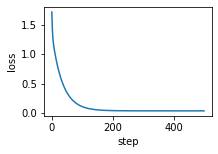

weight=-3.0226664543151855 bias=1.4959371089935303 counter=502


In [7]:
def sgd(params: Linear, gradient: Linear, lr: float = 1e-1):
    updated_params = jax.tree_map(lambda p, g: p - lr * g, params, gradient)
    return updated_params


losses = []
for step in range(500):
    grads, (loss, net) = gradient_fn(net, (x, y))

    params = sgd(net.parameters(), grads.parameters())
    net = net.update_parameters(params)
    losses.append(loss)


plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')
plt.show()
print(net)

**Note**:

1. `sgd(net.parameters(), grads.parameters())` ensures that we only update trainable parameters of `net`.
2. The estimated weight = `-3.02` and bias = `1.49` are very close to the ground truths. 
3. Counter=`502` correctly counts the number of forward passes.

Finally, let's plot the prediction of our trained model.

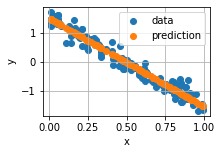

In [8]:
plot_prediction(net, (x, y))